# Importando bibliotecas


In [1]:
!pip install transformers

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatib

In [3]:
!pip install datasets

In [4]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 109.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


# Usando o arquivo classic4.csv




In [5]:
import BertTokenizer
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification


data_path = "sample_data/classic4.csv"
text_column_name = "text"
label_column_name = "class"

model_name = "distilbert-base-uncased"
test_size = 0.2
num_labels = 4

bt = BertTokenizer.BertTokenizer(data_path, text_column_name, label_column_name,
                                 model_name, test_size, num_labels)
train_dataset, test_dataset, df_label, df_test = bt.split_datasets()

In [6]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer


def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5676 [00:00<?, ? examples/s]

Map:   0%|          | 0/1419 [00:00<?, ? examples/s]

In [7]:
model = bt.create_model()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Configurando Treinamento

In [8]:
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics

)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-bc6034405ecb>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Treino e Salvamento do Modelo

In [9]:


trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.258700,0.227153,0.965469
2,0.137900,0.200386,0.965469
3,0.074900,0.234292,0.966878
4,0.059200,0.178945,0.963354
5,0.039800,0.181899,0.971106


TrainOutput(global_step=3550, training_loss=0.11410236090001925, metrics={'train_runtime': 911.9833, 'train_samples_per_second': 31.119, 'train_steps_per_second': 3.893, 'total_flos': 2257290829630368.0, 'train_loss': 0.11410236090001925, 'epoch': 5.0})

In [10]:
trainer.save_model('model_1')

## Avaliação

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       630
           1       0.97      0.93      0.95       303
           2       0.98      0.99      0.98       280
           3       0.97      0.99      0.98       206

    accuracy                           0.97      1419
   macro avg       0.97      0.97      0.97      1419
weighted avg       0.97      0.97      0.97      1419

Test Micro F1: 0.9711, Test Macro F1: 0.9708


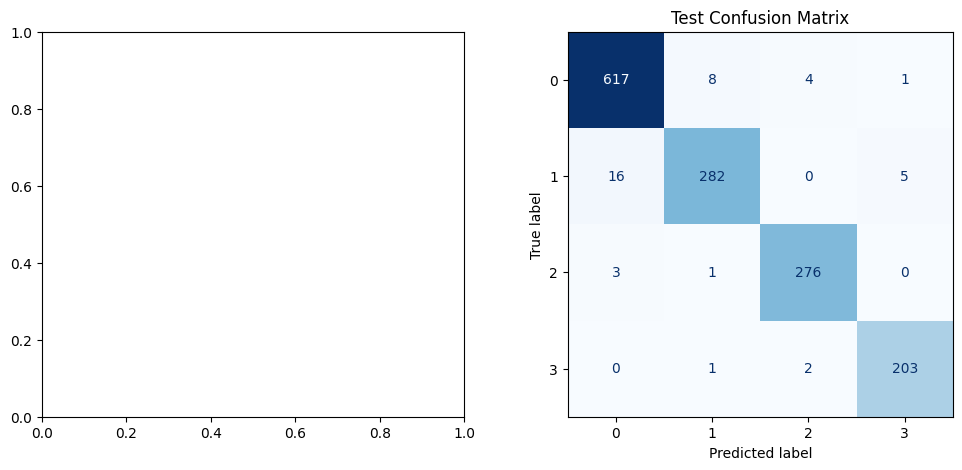

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
test_preds = trainer.predict(tokenized_test)
test_preds = np.argmax(test_preds[:3][0], axis=1)
test_GT = df_test['label'].tolist()

print("Test Classification Report:")
print(classification_report(test_GT, test_preds))

micro_f1_test = f1_score(test_GT, test_preds, average='micro')
macro_f1_test = f1_score(test_GT, test_preds, average='macro')

print(f"Test Micro F1: {micro_f1_test:.4f}, Test Macro F1: {macro_f1_test:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_test = confusion_matrix(test_GT, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Test Confusion Matrix")

plt.show()


# Usando o arquivo Dmoz-Science.csv

In [22]:
import BertTokenizer
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification


data_path = "sample_data/Dmoz-Science.csv"
text_column_name = "text"
label_column_name = "class"

model_name = "distilbert-base-uncased"
test_size = 0.2
num_labels = 12
bt = BertTokenizer.BertTokenizer(data_path, text_column_name, label_column_name,
                                 model_name, test_size, num_labels)
train_dataset, test_dataset, df_label, df_test = bt.split_datasets()

In [23]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer


def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [24]:
model = bt.create_model()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Configurando Treinamento

In [25]:
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics

)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-bc6034405ecb>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Treino e Salvamento do Modelo

In [26]:


trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.314200,1.043489,0.705000
2,0.815700,1.149986,0.748333
3,0.549300,1.128058,0.768333
4,0.350500,1.184825,0.773333
5,0.197900,1.256543,0.776667


TrainOutput(global_step=3000, training_loss=0.6455303471883138, metrics={'train_runtime': 234.2774, 'train_samples_per_second': 102.443, 'train_steps_per_second': 12.805, 'total_flos': 315769579843392.0, 'train_loss': 0.6455303471883138, 'epoch': 5.0})

In [27]:
trainer.save_model('model_1')

## Avaliação

Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       101
           1       0.85      0.87      0.86        93
           2       0.79      0.78      0.79       108
           3       0.71      0.83      0.76        76
           4       0.80      0.76      0.78       107
           5       0.71      0.78      0.75       102
           6       0.83      0.78      0.80       105
           7       0.84      0.84      0.84       104
           8       0.65      0.71      0.68        98
           9       0.82      0.84      0.83        94
          10       0.79      0.67      0.73       110
          11       0.66      0.62      0.64       102

    accuracy                           0.78      1200
   macro avg       0.78      0.78      0.78      1200
weighted avg       0.78      0.78      0.78      1200

Test Micro F1: 0.7767, Test Macro F1: 0.7771


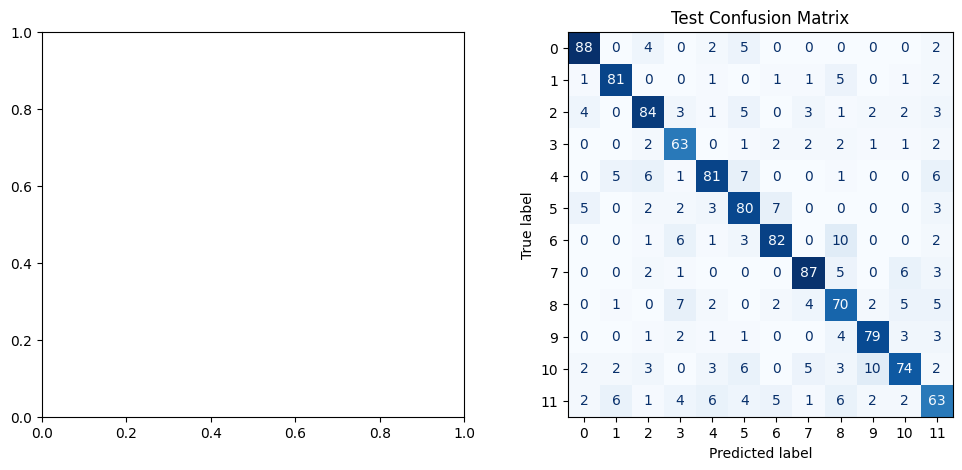

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
test_preds = trainer.predict(tokenized_test)
test_preds = np.argmax(test_preds[:3][0], axis=1)
test_GT = df_test['label'].tolist()

print("Test Classification Report:")
print(classification_report(test_GT, test_preds))

micro_f1_test = f1_score(test_GT, test_preds, average='micro')
macro_f1_test = f1_score(test_GT, test_preds, average='macro')

print(f"Test Micro F1: {micro_f1_test:.4f}, Test Macro F1: {macro_f1_test:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_test = confusion_matrix(test_GT, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Test Confusion Matrix")

plt.show()
